# Preparation

In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\seqFish-SpatialMouseAtlas',
 'D:\\anaconda\\envs\\STAGATE\\python38.zip',
 'D:\\anaconda\\envs\\STAGATE\\DLLs',
 'D:\\anaconda\\envs\\STAGATE\\lib',
 'D:\\anaconda\\envs\\STAGATE',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\stagate-1.0.1-py3.8.egg',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\Pythonwin']

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

In [4]:
import STAGATE

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\\anaconda\envs\STAligner\Lib\R'
os.environ['R_USER'] = 'D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2'

In [19]:
datasets = ["embryo1-2","embryo1-5","embryo2-2","embryo2-5","embryo3-2","embryo3-5"]
experiment_name = 'allEmbryo'
input_dir = 'G:/dataset/seqFish-SpatialMouseAtlas/output/python/'  # Replace it with your file path
output_dir = 'G:/dataset/seqFish-SpatialMouseAtlas/output/STAGATE/'  # Replace it with your file path

# load data

In [8]:
import anndata as ad
adata_list = {}
# for section_id in section_ids:
#     input_path = input_dir + section_id
#     temp_adata = sc.read_visium(path=input_path, count_file='filtered_feature_bc_matrix.h5')
#     temp_adata.var_names_make_unique()

#     # Truth_df = pd.read_csv(os.path.join(input_dir, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
#     # temp_adata.obs['Ground Truth'] = Truth_df.loc[temp_adata.obs_names, 1]

#     # # read the annotation
#     Ann_df = pd.read_csv(os.path.join(input_path, 'truth.csv'), index_col=0)
#     Ann_df.index = [str.replace(str.replace(x, '.', '-'), Ann_df['batch'][0] + '-', '') for x in Ann_df.index]
#     temp_adata.obs['Ground Truth'] = Ann_df.loc[temp_adata.obs_names, 'celltype'].astype('category')
    
#     # make the spot name unique
#     temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]

#     adata_list[section_id] = temp_adata.copy()

for dataset in datasets:
    # adata = sc.read_visium(input_dir + dataset)
    # adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    
    matrix = pd.read_csv(input_dir + dataset + "/matrix.csv", index_col=False)
    feature = pd.read_csv(input_dir + dataset + "/features.csv", index_col=0)
    feature.index.name = 'gene'
    barcode = pd.read_csv(input_dir + dataset + "/barcodes.csv", index_col=0)
    barcode.index.name = 'spot'
    adata = ad.AnnData(X=matrix.to_numpy().T, obs=barcode, var=feature)
    
    positions = pd.read_csv(input_dir + dataset + "/tissue_positions_list.csv", index_col=0, header=None)
    positions.drop(positions.columns[[0, 3, 4]], axis=1, inplace=True)
    positions.columns = ['x', 'y']
    adata.obsm['spatial'] = positions.values
    
    adata_label = pd.read_csv(input_dir + dataset + '/truth.csv', index_col=0)
    # adata_label.index = [str.replace(str.replace(x, '.', '-'), adata_label['batch'][0] + '-', '') for x in adata_label.index]
    adata.obs['batch'] = adata_label['batch']
    adata.obs['Ground Truth'] = adata_label.loc[adata.obs_names, 'celltype_mapped_refined'].astype('category')
    adata_list[dataset] = adata.copy()

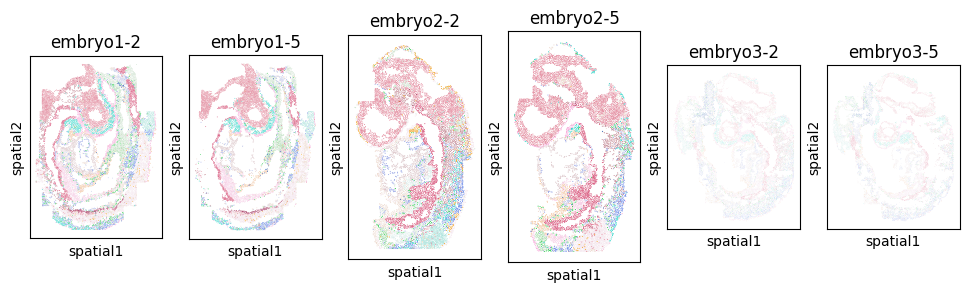

In [10]:
fig, axs = plt.subplots(1, len(datasets), figsize=(12, 3))
it=0
for section_id in datasets:
    if it == len(datasets):
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["Ground Truth"], title=section_id, show=False, spot_size = 1)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["Ground Truth"], title=section_id, show=False, spot_size = 1)
    it+=1

------Calculating spatial graph...
The graph contains 70134 edges, 11026 cells.
6.3608 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 55332 edges, 8425 cells.
6.5676 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 48042 edges, 8011 cells.
5.9970 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 43700 edges, 6880 cells.
6.3517 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 64558 edges, 12541 cells.
5.1478 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 58284 edges, 10653 cells.
5.4711 neighbors per cell on average.


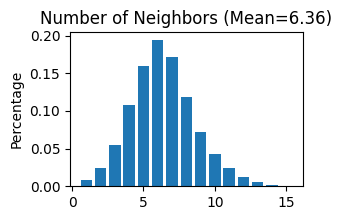

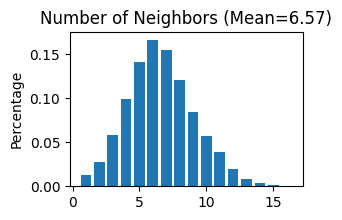

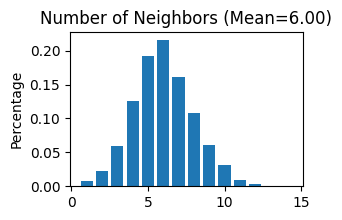

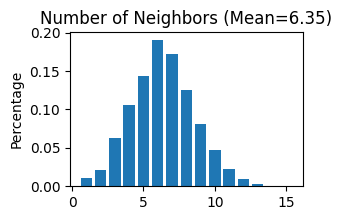

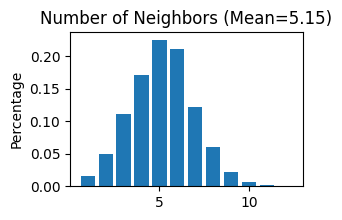

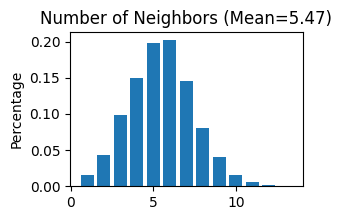

In [11]:
for section_id in datasets:
    if (section_id == "embryo3-2" or section_id == "embryo3-5"):
        STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=4)
    else:
        STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=2)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

# Conbat the scanpy objects and spatial networks

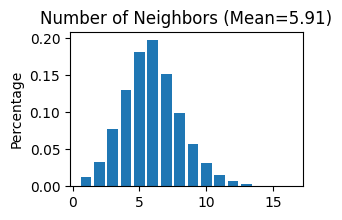

In [14]:
adata = sc.concat([adata_list[x] for x in datasets], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in datasets])
STAGATE.Stats_Spatial_Net(adata)

# Normalization

In [15]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Running STAGATE

In [16]:
adata

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'batch', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial'

In [17]:
%%time
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (57536, 351)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:22<00:00,  1.96s/it]


CPU times: total: 1h 49min 23s
Wall time: 16min 23s


In [18]:
print(adata)
print(type(adata.obsm['STAGATE']))

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'batch', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial', 'STAGATE'
<class 'numpy.ndarray'>


#### save embedding

In [22]:
# save embedding
np.savetxt(output_dir + experiment_name + '_STAGATE.csv', adata.obsm['STAGATE'], delimiter=",")

In [25]:
# import seaborn as sns
# slice_colors = sns.color_palette(n_colors = 6).as_hex()
series = adata.obs['Ground Truth']
series = series.astype("category")

celltype_num = len(series.value_counts().index)
celltypes = series.value_counts().index.tolist()

import seaborn as sns
colors = sns.color_palette(n_colors = celltype_num).as_hex()

num_cluster = celltype_num
print(num_cluster)

In [26]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

# louvein
# sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=num_cluster)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


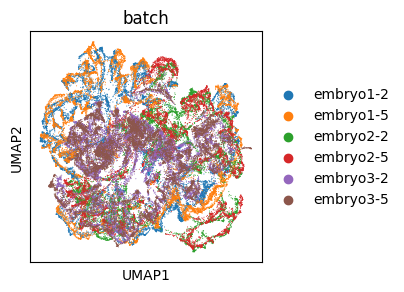

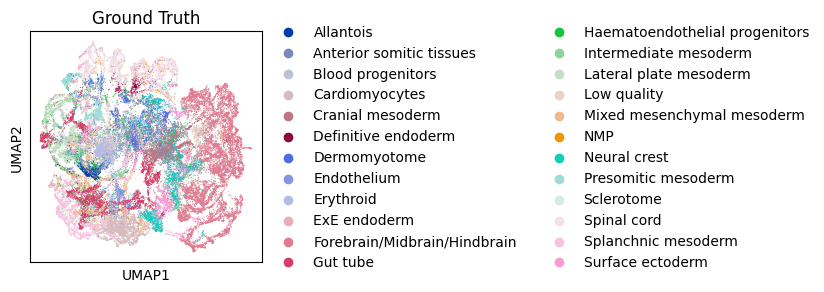

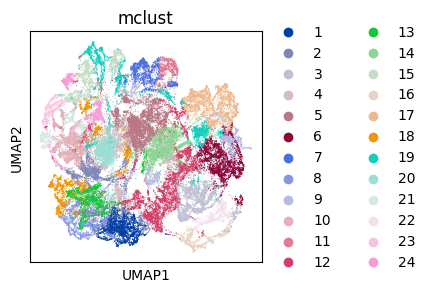

In [28]:
# adata.obs['batch_name'] = [x.split('_')[-1] for x in adata.obs_names]

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='batch')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Ground Truth')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')

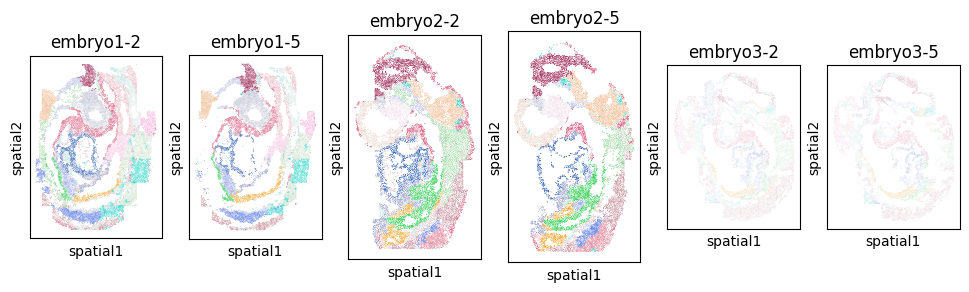

In [33]:
fig, axs = plt.subplots(1, len(datasets), figsize=(12, 3))
it=0
for section_id in datasets:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == len(datasets):
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False, spot_size =1)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False, spot_size =1)
    it+=1

# Calculate ARI

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score

for section_id in datasets:
    temp_adata = adata[adata.obs['batch']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID embryo1-2: 0.336
ARI of section ID embryo1-5: 0.345
ARI of section ID embryo2-2: 0.379
ARI of section ID embryo2-5: 0.338
ARI of section ID embryo3-2: 0.333
ARI of section ID embryo3-5: 0.321


# Visualization

NameError: name 'out_dir' is not defined

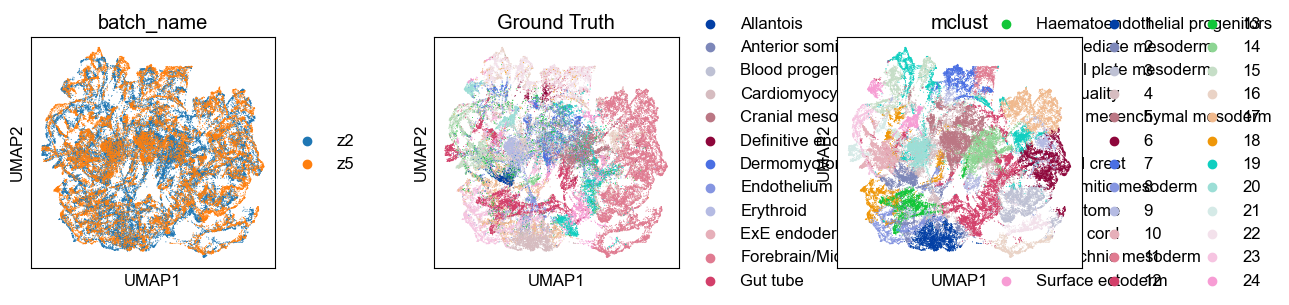

In [38]:
sc.pp.neighbors(adata, use_rep='STAGATE', random_state=666)
sc.tl.umap(adata, random_state=666)

section_color = sns.color_palette(n_colors = len(datasets)).as_hex()
section_color_dict = dict(zip(datasets, section_color))
adata.uns['batch_name_colors'] = [section_color_dict[x] for x in adata.obs.batch.cat.categories]
# adata.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata.obs['Ground Truth'], adata.obs['mclust'].values),
#                                          index=adata.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)
plt.savefig(output_dir + experiment_name + '_umap.png', dpi=300)

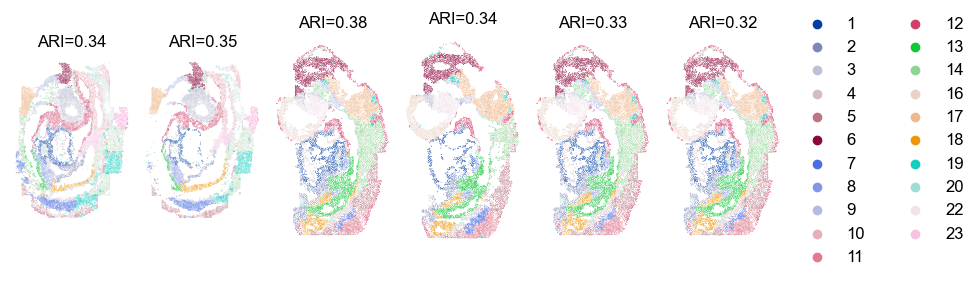

In [45]:
Batch_list = []
for section_id in datasets:
    Batch_list.append(adata[adata.obs['batch'] == section_id])

import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

spot_size = 1
title_size = 12
ARI_list = []
for bb in range(len(datasets)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, len(datasets), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
_sc_4 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[4], frameon=False,
                      spot_size=spot_size)
_sc_4[0].set_title("ARI=" + str(ARI_list[4]), size=title_size)
_sc_5 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[5], frameon=False,
                      spot_size=spot_size)
_sc_5[0].set_title("ARI=" + str(ARI_list[5]), size=title_size)

plt.savefig(output_dir + experiment_name + '_ARI.png', dpi=300)
plt.show()

# save

In [ ]:
print(type(adata))
print(adata.obsm)
print(adata)

print(adata.isbacked)
adata.filename = out_dir + expriment_name + '.h5ad'
print(adata.isbacked)